In [1]:
# read data: 30 ICs 
import nipype.interfaces.io as nio
import os
PD_ICA_file='/templateflow/PD_ICAs';
ICs_list=list(range(30))
ICs_list=["{:0>4d}".format(x) for x in ICs_list]
# file import
ds_ic = nio.DataGrabber(infields=['IC_id'])
ds_ic.inputs.base_directory = PD_ICA_file # database
ds_ic.inputs.template = 'melodic_IC_%4s.nii.gz' # from cwd
ds_ic.inputs.sort_filelist = True
ds_ic.inputs.IC_id = ICs_list
res_ic = ds_ic.run()
ic_list=res_ic.outputs.outfiles
# read local ic
PD_ICA_local_file='/output/PD_ICA/ICA_local/stats';
ICs_local_list=[x+1 for x in list(range(19))]
#ICs_local_list=["{:0>4d}".format(x) for x in ICs_local_list]
# file import
ds_local_ic = nio.DataGrabber(infields=['IC_id'])
ds_local_ic.inputs.base_directory = PD_ICA_local_file # database
ds_local_ic.inputs.template = 'thresh_zstat%s.nii.gz' # from cwd
ds_local_ic.inputs.sort_filelist = True
ds_local_ic.inputs.IC_id = ICs_local_list
res_local_ic = ds_local_ic.run()
ic_local_list=res_local_ic.outputs.outfiles
#print(ic_local_list)
# read data: 3 study groups by sub_list 
GROUPS=['PD','ET','NC']
OUT_DIR='/output/PD_ICA/'
SUB_LIST=[]; AGE_LIST=[]; JCOB_LIST=[];
print('Local data: ')
for group_name in GROUPS:
    current_group=group_name
    current_sub_list_file = '/codes/devel/PD_Marker/'+current_group+'_info_ICA.list'
    # create dir for output
    current_OUT_DIR=OUT_DIR+current_group+'/'
    if not os.path.exists(current_OUT_DIR):
        os.makedirs(current_OUT_DIR)
    #read sub list
    with open(current_sub_list_file, 'r') as f_sub:
        sub_list_raw= f_sub.readlines()
    sub_list = [x[0:-1].split('\t')[0] for x in sub_list_raw] # remove 
    age_list = [int(x[0:-1].split('\t')[1]) for x in sub_list_raw]
    SUB_LIST.append(sub_list);  AGE_LIST.append(age_list);
    N_sub=len(sub_list)
    print(group_name, ': ', N_sub)
    # grab group Jacobians
    ds_jacobian = nio.DataGrabber(infields=['sub_id'])
    ds_jacobian.inputs.base_directory = current_OUT_DIR # database
    ds_jacobian.inputs.template = '%s_desc-preproc_T1w_space-MNI2009c_Warp_Jacobian.nii.gz' # from cwd
    ds_jacobian.inputs.sort_filelist = True
    ds_jacobian.inputs.sub_id = sub_list
    res_jacobian = ds_jacobian.run()
    jacobian_list=res_jacobian.outputs.outfiles
    JCOB_LIST.append(jacobian_list)
pd_sub_list = SUB_LIST[0]; et_sub_list = SUB_LIST[1]; nc_sub_list = SUB_LIST[2]; 
pd_age_list = AGE_LIST[0]; et_age_list = AGE_LIST[1]; nc_age_list = AGE_LIST[2];
pd_jaco_list=JCOB_LIST[0]; et_jaco_list=JCOB_LIST[1]; nc_jaco_list=JCOB_LIST[2];
# read all the AD-subjects
import pandas as pd
sub_list_file = '/output/PPMI_DBM_AD/subject_IDs.csv'
ad_sub_list_df=pd.read_csv(sub_list_file, sep=',', header=0, index_col=0)
ad_sub_label= ['PD' if x==1 else 'NC' for x in list(ad_sub_list_df['PD'])]
N_ad_sub=len(ad_sub_label); N_ad_PD=sum(list(ad_sub_list_df['PD'])); N_ad_NC=N_ad_sub-N_ad_PD;
ad_sub_list = [str(x) for x in list(range(N_ad_sub))]
ad_jacobian_dir='/output/PPMI_DBM_AD/sub_dbm/'
ad_jacobian = nio.DataGrabber(infields=['sub_id'])
ad_jacobian.inputs.base_directory = ad_jacobian_dir # database
ad_jacobian.inputs.template = 'sub-%s_dbm.nii.gz' # from cwd
ad_jacobian.inputs.sort_filelist = True
ad_jacobian.inputs.sub_id = ad_sub_list
res_ad_jacobian = ad_jacobian.run()
ad_jacobian_list=res_ad_jacobian.outputs.outfiles
print('AD data: \nPD : ', N_ad_PD, '\nNC : ', N_ad_NC)

201001-19:44:47,437 nipype.utils WARNING:
	 A newer version (1.5.1) of nipy/nipype is available. You are using 1.5.0
Local data: 
PD :  40
ET :  29
NC :  33
AD data: 
PD :  232 
NC :  117


In [2]:
# read all group Jacobian data, and (all IC)*(all IMG) functions
import time
import nibabel as nib
def grab_groupXICA(IC_list, img_list, sub_list, sv_path):
    import nibabel as nib
    from nilearn.image import resample_to_img
    from nilearn.image import math_img
    from scipy import stats
    import numpy as np
    x_list=[]; y_list=[];
    N_sub=len(img_list)
    N_IC=len(IC_list)
    y_list=[]
    #print('gourp++')
    for i_ic in range(N_IC):
        print('ic: ', str(i_ic))
        ic_img=nib.load(IC_list[i_ic])
        x_list=[]
        for i_sub in range(N_sub):
            # cal img * img
            sub_img=nib.load(img_list[i_sub])
            if sub_img.shape[0] > ic_img.shape[0]:
                sub_img_re = resample_to_img(sub_img, ic_img)
                ic_img_re  = ic_img;
            elif sub_img.shape[0] == ic_img.shape[0]:
                sub_img_re = sub_img;
                ic_img_re  = ic_img;
            else:
                ic_img_re  = resample_to_img(ic_img, sub_img)
                sub_img_re = sub_img;
            sub_img_x  = math_img("img1 * img2", img1=ic_img_re, img2=sub_img_re)
            nib.save(sub_img_x, sv_path+sub_list[i_sub]+'-xIC'+str(i_ic)+'.nii.gz')
            ic_data = ic_img_re.get_fdata().reshape(-1);
            nz_pos=np.flatnonzero(ic_data)
            ic_val=list(ic_data.ravel()[nz_pos])
            sub_dat = sub_img_re.get_fdata().reshape(-1);
            sub_val=list(stats.zscore(sub_dat.ravel()[nz_pos]))
            x_list.append(np.corrcoef(sub_val, ic_val)[0,1])
        y_list.append(x_list)
    return y_list

In [12]:
## AD-IC x AD-IMG
## constants
N_AD_IC=len(ic_list); N_AB_IC=len(ic_local_list);
N_AB_PD=len(pd_sub_list); N_AB_ET=len(et_sub_list); N_AB_NC=len(nc_sub_list);
N_AD_PD= N_ad_PD; N_AD_NC=N_ad_NC;
AD_AB_OUT_DIR = '/output/AD-IC_AB-IMG/'
ab_sub_label  = ['PD']*N_AB_PD+['NC']*N_AB_NC+['ET']*N_AB_ET
ab_sub_y      = [1]*N_AB_PD+[0]*N_AB_NC+[-1]*N_AB_ET
ab_sub_list   = pd_sub_list+nc_sub_list+et_sub_list
ab_jacob_list = pd_jaco_list+nc_jaco_list+et_jaco_list
N_ab_sub = len(ab_sub_list);
## AD-IC x AB-IMG
t0=time.time()
print('Abbas dataset: ', N_ab_sub)
ab_jaco_corr_list=grab_groupXICA(ic_list, ab_jacob_list, ab_sub_list, AD_AB_OUT_DIR)
print('Abbas group X AD IC takes: ', str(time.time()-t0))
#AD_AD_OUT_DIR = '/output/AD-IC_AD-IMG/'
#t1=time.time()
#ad_jaco_corr_list=grab_groupXICA(ic_list, ad_jacobian_list, ad_sub_list, AD_AD_OUT_DIR)
#print('AD group X AD IC takes: ', str(time.time()-t1))
import numpy as np
import pandas as pd
ab_sub_y      = [1]*N_AB_PD+[0]*N_AB_NC+[-1]*N_AB_ET
ab_ic_corr=np.array(ab_jaco_corr_list).T
ad_ic_names=['ic'+str(x) for x in list(range(N_AD_IC))]
ab_group_corr=pd.DataFrame(ab_ic_corr, columns=ad_ic_names)
ab_group_corr['label']=ab_sub_label
ab_group_corr['PD']=list(ab_sub_y)
ab_group_corr['ID']=ab_sub_list
ab_group_corr.to_csv('ab_all-ic_mean-corr.csv')

In [ ]:
## AB-IC x AD-IMG
AB_AB_OUT_DIR = '/output/AB-IC_AB-IMG/'
t0=time.time()
ab_ab_jaco_corr_list=grab_groupXICA(ic_local_list, ab_jacob_list, ab_sub_list, AB_AB_OUT_DIR)
print('AB IC takes X AB group: ', str(time.time()-t0))

import numpy as np
import pandas as pd
ab_sub_y      = [1]*N_AB_PD+[0]*N_AB_NC+[-1]*N_AB_ET
ab_ab_ic_corr    =np.array(ab_ab_jaco_corr_list).T
ab_ic_names   =['ic'+str(x) for x in list(range(N_AB_IC))]
ab_ab_group_corr =pd.DataFrame(ab_ab_ic_corr, columns=ab_ic_names)
ab_ab_group_corr['label']=ab_sub_label
ab_ab_group_corr['PD']=list(ab_sub_y)
ab_ab_group_corr['ID']=ab_sub_list
ab_ab_group_corr.to_csv('abxab-ic_mean-corr.csv')

## AB-IC x AD-IMG
AB_AD_OUT_DIR = '/output/AB-IC_AD-IMG/'
t1=time.time()
ab_ad_jaco_corr_list=grab_groupXICA(ic_local_list, ad_jacobian_list, ad_sub_list, AB_AD_OUT_DIR)
print('AB IC takes X AD group: ', str(time.time()-t1))
ab_ad_ic_corr    =np.array(ab_ad_jaco_corr_list).T
ab_ic_names   =['ic'+str(x) for x in list(range(N_AB_IC))]
ab_ad_group_corr =pd.DataFrame(ab_ad_ic_corr, columns=ab_ic_names)
ab_ad_group_corr['label']=ad_sub_label
ab_ad_group_corr['PD']=list(ad_sub_list_df['PD'])
ab_ad_group_corr['ID']=ad_sub_list_df.index
ab_ad_group_corr.to_csv('abxad-ic_mean-corr.csv')

In [6]:
## ET-IC x AB-IMG
# read ET ic
ET_ICA_file='/output/PD_ICA/ICA_local_et+nc/stats';
N_et_ic=41
ET_IC_list=[x+1 for x in list(range(N_et_ic))]
#ICs_local_list=["{:0>4d}".format(x) for x in ICs_local_list]
# file import
ds_et_ic = nio.DataGrabber(infields=['IC_id'])
ds_et_ic.inputs.base_directory = ET_ICA_file # database
ds_et_ic.inputs.template = 'thresh_zstat%s.nii.gz' # from cwd
ds_et_ic.inputs.sort_filelist = True
ds_et_ic.inputs.IC_id = ET_IC_list
res_et_ic = ds_et_ic.run()
ic_et_list=res_et_ic.outputs.outfiles

## constants
import os
N_ad_ic=len(ic_list); N_ab_ic=len(ic_local_list);
N_ab_pd=len(pd_sub_list); N_ab_et=len(et_sub_list); N_ab_nc=len(nc_sub_list);
N_ad_pd= N_ad_PD; N_ad_nc=N_ad_NC;
# AB and AD subjust data preparation
ET_AB_OUT_DIR = '/output/ET-IC_AB-IMG/'; ET_AD_OUT_DIR = '/output/ET-IC_AD-IMG/'
if not os.path.exists(ET_AB_OUT_DIR):
    os.makedirs(ET_AB_OUT_DIR)
if not os.path.exists(ET_AD_OUT_DIR):
    os.makedirs(ET_AD_OUT_DIR)
ab_sub_label  = ['PD']*N_ab_pd+['NC']*N_ab_nc+['ET']*N_ab_et
ab_sub_y      = [1]*N_ab_pd+[0]*N_ab_nc+[-1]*N_ab_et
ab_sub_list   = pd_sub_list+nc_sub_list+et_sub_list
ab_jacob_list = pd_jaco_list+nc_jaco_list+et_jaco_list
N_ab_sub = len(ab_sub_list);

## et-IC x AB-IMG
t0=time.time()
print('Abbas dataset: ', N_ab_sub)
et_ab_jaco_corr=grab_groupXICA(ic_et_list, ab_jacob_list, ab_sub_list, ET_AB_OUT_DIR)
print('ET-IC x Abbas group takes: ', str(time.time()-t0))
import numpy as np
import pandas as pd
ab_sub_y      = [1]*N_AB_PD+[0]*N_AB_NC+[-1]*N_AB_ET
et_ab_ic_corr=np.array(et_ab_jaco_corr).T
et_ic_names=['ic'+str(x) for x in list(range(N_et_ic))]
et_ab_group_corr=pd.DataFrame(et_ab_ic_corr, columns=et_ic_names)
et_ab_group_corr['label']=ab_sub_label
et_ab_group_corr['PD']=list(ab_sub_y)
et_ab_group_corr['ID']=ab_sub_list
et_ab_group_corr.to_csv('et-ab_mean-corr.csv')

Abbas dataset:  102
ic:  0
ic:  1
ic:  2
ic:  3
ic:  4
ic:  5
ic:  6
ic:  7
ic:  8
ic:  9
ic:  10
ic:  11
ic:  12
ic:  13
ic:  14


KeyboardInterrupt: 

In [ ]:
## et-IC x AD-IMG
t0=time.time()
print('PPMI dataset: ', N_ad_sub)
et_ad_jaco_corr=grab_groupXICA(ic_et_list, ad_jacobian_list, ad_sub_list, ET_AD_OUT_DIR)
print('ET-IC x PPMI group takes: ', str(time.time()-t0))
import numpy as np
import pandas as pd
ab_sub_y      = [1]*N_AB_PD+[0]*N_AB_NC+[-1]*N_AB_ET
et_ad_corr=np.array(et_ad_jaco_corr).T
et_ic_names=['ic'+str(x) for x in list(range(N_et_ic))]
et_ad_group_corr=pd.DataFrame(et_ad_corr, columns=et_ic_names)
et_ad_group_corr['label']=ad_sub_label
et_ad_group_corr['PD']=list(ad_sub_list_df['PD'])
et_ad_group_corr['ID']=ad_sub_list_df.index
et_ad_group_corr.to_csv('et-ad_mean-corr.csv')

In [ ]:
## ET-IC x AB-IMG
## constants
N_AD_IC=len(ic_list); N_AB_IC=len(ic_local_list);
N_AB_PD=len(pd_sub_list); N_AB_ET=len(et_sub_list); N_AB_NC=len(nc_sub_list);
N_AD_PD= N_ad_PD; N_AD_NC=N_ad_NC;
AD_AB_OUT_DIR = '/output/AD-IC_AB-IMG/'
ab_sub_label  = ['PD']*N_AB_PD+['NC']*N_AB_NC+['ET']*N_AB_ET
ab_sub_y      = [1]*N_AB_PD+[0]*N_AB_NC+[-1]*N_AB_ET
ab_sub_list   = pd_sub_list+nc_sub_list+et_sub_list
ab_jacob_list = pd_jaco_list+nc_jaco_list+et_jaco_list
N_ab_sub = len(ab_sub_list);
## AD-IC x AB-IMG
t0=time.time()
print('Abbas dataset: ', N_ab_sub)
ab_jaco_corr_list=grab_groupXICA(ic_list, ab_jacob_list, ab_sub_list, AD_AB_OUT_DIR)
print('Abbas group X AD IC takes: ', str(time.time()-t0))
#AD_AD_OUT_DIR = '/output/AD-IC_AD-IMG/'
#t1=time.time()
#ad_jaco_corr_list=grab_groupXICA(ic_list, ad_jacobian_list, ad_sub_list, AD_AD_OUT_DIR)
#print('AD group X AD IC takes: ', str(time.time()-t1))
import numpy as np
import pandas as pd
ab_sub_y      = [1]*N_AB_PD+[0]*N_AB_NC+[-1]*N_AB_ET
ab_ic_corr=np.array(ab_jaco_corr_list).T
ad_ic_names=['ic'+str(x) for x in list(range(N_AD_IC))]
ab_group_corr=pd.DataFrame(ab_ic_corr, columns=ad_ic_names)
ab_group_corr['label']=ab_sub_label
ab_group_corr['PD']=list(ab_sub_y)
ab_group_corr['ID']=ab_sub_list
ab_group_corr.to_csv('ab_all-ic_mean-corr.csv')

In [ ]:
# old: read all group Jacobian data, and 1 IC multiply IC7*IMG
import time
import nibabel as nib
#i_PD_IC=7
pd_jaco_x_list=[]; et_jaco_x_list=[]; nc_jaco_x_list=[]
#PD_ICA_img=nib.load(ic_list[i_PD_IC]);
def grab_groupXICA(ic_img, img_list):
    import nibabel as nib
    from nilearn.image import resample_to_img
    from nilearn.image import math_img
    from scipy import stats
    import numpy as np
    x_list=[]; y_list=[];
    N_sub=len(img_list)
    #print('gourp++')
    for i in range(N_sub):
        # cal img * img
        print('*')
        sub_img=nib.load(img_list[i])
        if sub_img.shape[0] > ic_img.shape[0]:
            sub_img_re = resample_to_img(sub_img, ic_img)
            ic_img_re  = ic_img;
        elif sub_img.shape[0] == ic_img.shape[0]:
            sub_img_re = sub_img;
            ic_img_re  = ic_img;
        else:
            ic_img_re  = resample_to_img(ic_img, sub_img)
            sub_img_re = sub_img;
        sub_img_x  = math_img("img1 * img2", img1=ic_img_re, img2=sub_img_re)
        x_list.append(sub_img_x)
        # cal naive corr
        ic_data = ic_img_re.get_fdata().reshape(-1);
        nz_pos=np.flatnonzero(ic_data)
        ic_val=list(ic_data.ravel()[nz_pos])
        sub_dat = sub_img_re.get_fdata().reshape(-1);
        sub_val=list(stats.zscore(sub_dat.ravel()[nz_pos]))
        y_list.append(np.corrcoef(sub_val, ic_val)[0,1])
    return [x_list, y_list]

## constants
N_AD_IC=len(ic_list); N_AB_IC=len(ic_local_list);
N_AB_PD=len(pd_sub_list); N_AB_ET=len(et_sub_list); N_AB_NC=len(nc_sub_list);
N_AD_PD= N_ad_PD; N_AD_NC=N_ad_NC;


AD_AB_OUT_DIR = '/output/AD-IC_AB-IMG/'
ab_sub_label  = ['PD']*N_AB_PD+['NC']*N_AB_NC+['ET']*N_AB_ET
ab_sub_list   = pd_sub_list+nc_sub_list+et_sub_list
ab_jacob_list = pd_jaco_list+nc_jaco_list+et_jaco_list
N_ab_sub = len(ab_sub_list);

## AD-IC x AB-IMG
t0=time.time()
[ab_jaco_x_list, ab_jaco_corr_list]=[grab_groupXICA(nib.load(x), ab_jacob_list) for x in ic_list];
for i_ic in range(N_IC):
    print('Abbas dataset: ', i_ic, N_ab_sub)
    for i_sub in range(N_ab_sub):
        nib.save(ab_jaco_x_list[i_ic][i_sub], AD_AB_OUT_DIR+ab_sub_list[i_sub]+'-xIC'+str(i_ic)+'.nii.gz');
print('Abbas group X AD IC takes: ', str(time.time()-t0))

## AD-IC x AD-IMG
AD_AB_OUT_DIR = '/output/AD-IC_AD-IMG/'
t1=time.time()
[ad_jaco_x_list, ad_jaco_corr_list]=[grab_groupXICA(nib.load(x), ad_jacobian_list) for x in ic_list];
for i_ic in range(N_IC):
    print('AD dataset: ', i_ic, N_ad_sub)
    for i_sub in range(N_ad_sub):
        nib.save(ad_jaco_x_list[i_ic][i_sub], AD_AD_OUT_DIR+ad_sub_list[i_sub]+'-xIC'+str(i_ic)+'.nii.gz');
print('AD group X AD IC takes: ', str(time.time()-t1))

In [2]:
# old: corr IC * subj
import nibabel as nib
import time
ICx_OUT_DIR = '/output/PD_ICA/IC_Ximg/'
N_IC=len(ic_list); N_PD=len(pd_sub_list); N_ET=len(et_sub_list) ;N_NC=len(nc_sub_list);
nc_jaco_x_list=[]
i_PD_IC=7
PD_ICA_img=nib.load(ic_list[i_PD_IC]);

def grab_group_corr_ICA_all_sv(ic_list, img_list, id_list, out_dir):
    import nibabel as nib
    from nilearn.image import resample_to_img
    from nilearn.image import math_img
    from scipy import stats
    import numpy as np
    x_list=[]; 
    N_ic=len(ic_list);
    N_sub=len(img_list);
    #print('gourp++')
    for j in range(N_ic):
        y_list=[]
        for i in range(N_sub):
            # cal img * img
            ic_img=nib.load(ic_list[j])
            sub_img=nib.load(img_list[i])
            sub_img_re = resample_to_img(sub_img, ic_img)
            #sub_img_x  = math_img("img1 * img2", img1=ic_img, img2=sub_img_re)
            #nib.save(sub_img_x, out_dir+id_list[i]+'-xIC'+str(j)+'.nii.gz');
            # cal naive corr
            ic_data = ic_img.get_fdata().reshape(-1);
            nz_pos=np.flatnonzero(ic_data)
            ic_val=list(ic_data.ravel()[nz_pos])
            sub_dat = sub_img_re.get_fdata().reshape(-1);
            sub_val=list(stats.zscore(sub_dat.ravel()[nz_pos]))
            #_list.append([sub_img_x, np.corrcoef(sub_val, ic_val)[0,1]])
            y_list.append(np.corrcoef(sub_val, ic_val)[0,1])
        x_list.append(y_list)
    return x_list
##
# just look at ic7
ic7_list=[ic_list[i_PD_IC]]
N_IC=len(ic_list); N_PD=len(pd_sub_list); N_ET=len(et_sub_list) ;N_NC=len(nc_sub_list);
t0=time.time()
nc_jaco_corr_list=grab_group_corr_ICA_all_sv(ic7_list, nc_jaco_list, nc_sub_list, ICx_OUT_DIR)
print('NC group corr IC takes: ', str(time.time()-t0))
pd_jaco_corr_list=grab_group_corr_ICA_all_sv(ic7_list, pd_jaco_list, pd_sub_list, ICx_OUT_DIR)
print('NC+PD group corr IC takes: ', str(time.time()-t0))
et_jaco_corr_list=grab_group_corr_ICA_all_sv(ic7_list, et_jaco_list, et_sub_list, ICx_OUT_DIR)
print('all group corr IC takes: ', str(time.time()-t0))
import pandas as pd
ic7_corr=pd_jaco_corr_list[0]+et_jaco_corr_list[0]+nc_jaco_corr_list[0]
ic_corr_lable=['PD']*N_PD+['ET']*N_ET+['NC']*N_NC
group_corr=pd.DataFrame({'ic_corr': ic7_corr, 'label': ic_corr_lable})
group_corr.to_csv('group_ic-sub_corr.csv')
print(group_corr)

NC group corr IC takes:  116.20346236228943
NC+PD group corr IC takes:  389.0855815410614
all group corr IC takes:  676.0446200370789


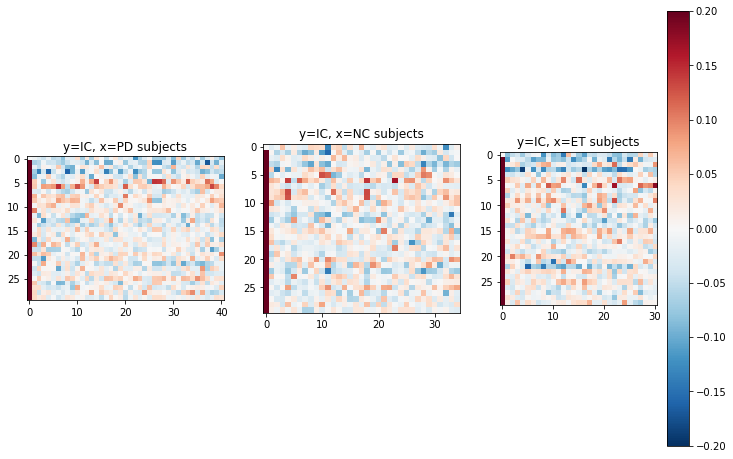

In [66]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use({'figure.figsize':(12, 8)})
vmin1=-.2; vmax1 = .2
df=[df_1, df_2, df_3];
# Fixing random state for reproducibility
#np.random.seed(19680801)
fig, axs = plt.subplots(1, 3)

cm = ['RdBu_r', 'viridis']
ax2 = axs[1]
pcm2 = ax2.imshow(df_1, cmap=cm[0], vmin= vmin1, vmax = vmax1)
ax2.set_title("y=IC, x=NC subjects")
#fig.colorbar(pcm1, ax=ax1)
ax1 = axs[0]
pcm1 = ax1.imshow(df_2, cmap=cm[0], vmin= vmin1, vmax = vmax1)
ax1.set_title("y=IC, x=PD subjects")
ax3 = axs[2]
pcm3 = ax3.imshow(df_3, cmap=cm[0], vmin= vmin1, vmax = vmax1)
ax3.set_title("y=IC, x=ET subjects")
fig.colorbar(pcm3, ax=ax3)
plt.show()

In [ ]:
# calculate image naive corr
import nibabel as nib
import numpy as np
PD_ICA_img=nib.load(ic_list[i_PD_IC]);
def cal_groupCorr(ic_img, img_list):
    import nibabel as nib
    from nilearn.image import resample_to_img
    from nilearn.image import math_img
    x_list=[];
    N_sub=len(img_list)
    for i in range(N_sub):
        sub_img=nib.load(img_list[i])
        sub_img_re = resample_to_img(sub_img, ic_img)
        #ic_data = ic_img.get_fdata().reshape(-1);
        nz_pos=np.flatnonzero(ic_data)
        ic_val=list(ic_data.ravel()[nz_pos])
        sub_val=list(stats.zscore(sub_dat.ravel()[nz_pos]))
        print(len(ic_val), len(sub_val))
        x_list.append(np.corrcoef(sub_dat, ic_val)[0,1])
    return x_list
pd_jaco_corr_list=cal_groupCorr(PD_ICA_img, pd_jaco_list); 
et_jaco_corr_list=cal_groupCorr(PD_ICA_img, et_jaco_list); 
nc_jaco_corr_list=cal_groupCorr(PD_ICA_img, nc_jaco_list);

In [9]:
pd_jaco_x_list_mean = [np.mean(x.get_fdata()) for x in pd_jaco_x_list]
et_jaco_x_list_mean = [np.mean(x.get_fdata()) for x in et_jaco_x_list]
nc_jaco_x_list_mean = [np.mean(x.get_fdata()) for x in nc_jaco_x_list]
#pd_age_list, et_age_list, nc_age_list;
#a=np.array(pd_jaco_x_list[0].get_fdata())
print(np.mean(pd_jaco_x_list_mean))
print(np.mean(et_jaco_x_list_mean))
print(np.mean(nc_jaco_x_list_mean))
import statsmodels

0.05656469500087711
0.057851655543776644
0.056640938817557565


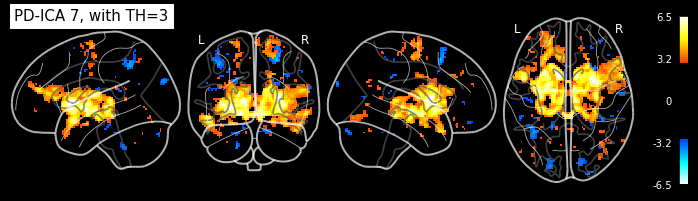

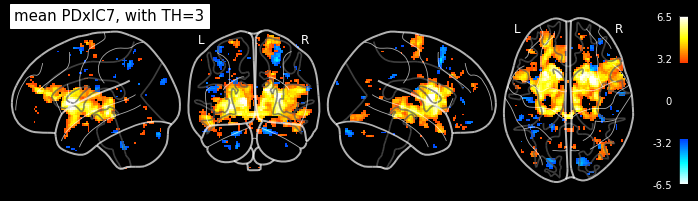

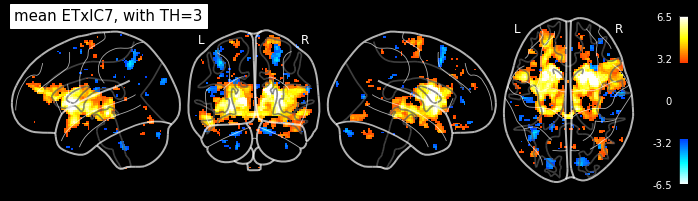

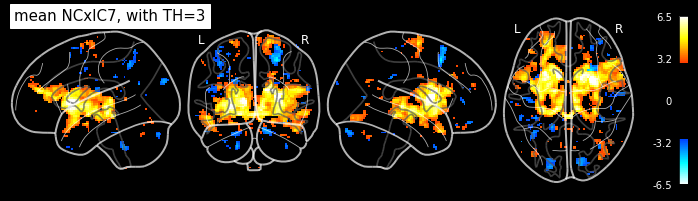

In [13]:
# plot group mean
TH=3
VMIN= 3; VMAX=6.5;
plotting.plot_glass_brain(PD_ICA_img, title='PD-ICA '+str(i_IC)+', with TH='+str(TH), display_mode='lyrz',
                          black_bg=True, colorbar=True, plot_abs=False, vmin=VMIN, vmax=VMAX, threshold=TH)
plotting.plot_glass_brain(pd4D_mean, title='mean PDxIC'+str(i_IC)+', with TH='+str(TH), display_mode='lyrz',
                          black_bg=True, colorbar=True, plot_abs=False, vmin=VMIN, vmax=VMAX, threshold=TH)
plotting.plot_glass_brain(et4D_mean, title='mean ETxIC'+str(i_IC)+', with TH='+str(TH), display_mode='lyrz',
                          black_bg=True, colorbar=True, plot_abs=False, vmin=VMIN, vmax=VMAX,threshold=TH)
plotting.plot_glass_brain(nc4D_mean, title='mean NCxIC'+str(i_IC)+', with TH='+str(TH), display_mode='lyrz',
                          black_bg=True, colorbar=True, plot_abs=False, vmin=VMIN, vmax=VMAX,threshold=TH)

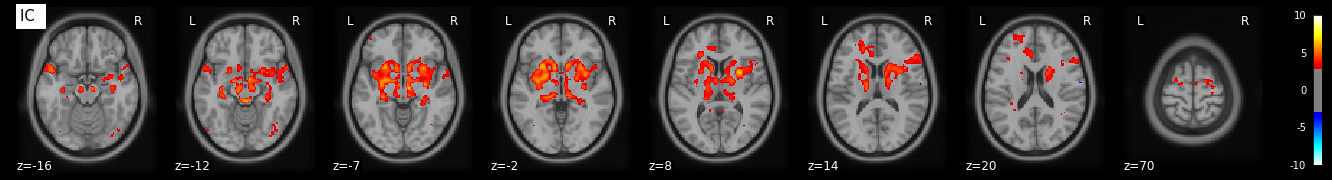

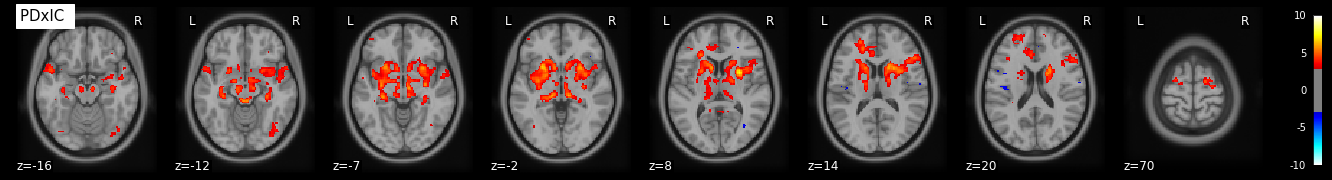

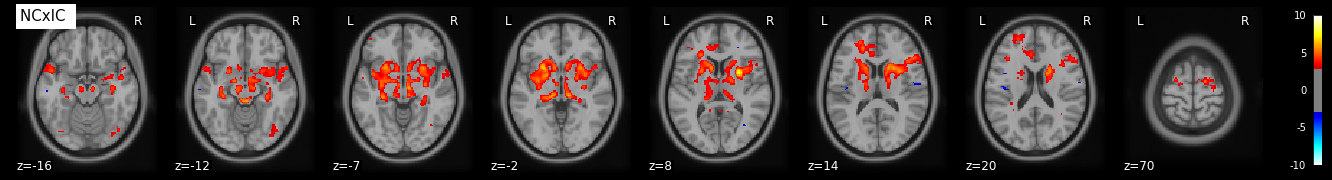

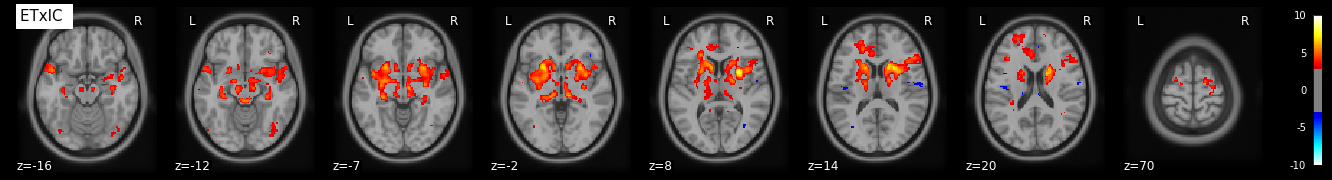

In [24]:
PD_ICA_SLICES=[-16, -12, -7, -2,  8, 14, 20, 70]
VMIN= 1; VMAX=10
plotting.plot_stat_map(PD_ICA_img, bg_img=atlas_09_masked, display_mode='z', threshold=3, \
                       title="IC ", vmax=VMAX, draw_cross=False, cut_coords=PD_ICA_SLICES)
plotting.plot_stat_map(pd4D_mean, bg_img=atlas_09_masked, display_mode='z', threshold=3, \
                       title="PDxIC ", vmax=VMAX, draw_cross=False, cut_coords=PD_ICA_SLICES)
plotting.plot_stat_map(nc4D_mean, bg_img=atlas_09_masked, display_mode='z', threshold=3, \
                       title="NCxIC ", vmax=VMAX, draw_cross=False, cut_coords=PD_ICA_SLICES)
plotting.plot_stat_map(et4D_mean, bg_img=atlas_09_masked, display_mode='z', threshold=3, \
                       title="ETxIC ", vmax=VMAX, draw_cross=False, cut_coords=PD_ICA_SLICES)